<h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria" align="center">Item-Based Sales Forecasting Using XGBRegressor</h1> 

Dataset: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

**Data fields**

- **date** - Date of the sale data. There are no holiday effects or store closures.
- **store** - Store ID
- **item** - Item ID
- **sales** - Number of items sold at a particular store on a particular date.


In this project, the goal is to forecast 3-month sales for 50 different products in 10 different stores when given 5 years of store item sales data.

<a id='import'></a>
<h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Importing Basic Libraries and Loading Dataset</h1> 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data= pd.read_csv('train.csv', parse_dates = ['date'])
train_data

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [92]:
test_data= pd.read_csv('test.csv', parse_dates = ['date'])
test_data

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [4]:
data= pd.concat([train_data, test_data],sort= False)
data

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


<a id='understand'></a>
<h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Understanding Dataset</h1> 

In [5]:
data.shape

(958000, 5)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


There are null values, because test data has not sales values and train data has not id values, and no duplicate row:

In [7]:
data.isnull().sum()

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

In [8]:
data[data.duplicated()]

,date,store,item,sales,id


10 stores and 50 items:

In [9]:
data['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [10]:
data['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

Summary Stats for each store:

In [11]:
data.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                    
       count        sum       mean median        std  min    max
store                                                           
1      91300  4315603.0  47.268379   44.0  24.006252  1.0  155.0
2      91300  6120128.0  67.033165   62.0  33.595810  3.0  231.0
3      91300  5435144.0  59.530602   55.0  29.974102  3.0  196.0
4      91300  5012639.0  54.902946   51.0  27.733097  4.0  186.0
5      91300  3631016.0  39.770164   37.0  20.365757  2.0  130.0
6      91300  3627670.0  39.733516   37.0  20.310451  0.0  134.0
7      91300  3320009.0  36.363735   34.0  18.684825  1.0  122.0
8      91300  5856169.0  64.142048   60.0  32.231751  4.0  204.0
9      91300  5025976.0  55.049025   51.0  27.832186  4.0  195.0
10     91300  5360158.0  58.709288   54.0  29.554994  3.0  187.0

Summary Stats for each item:

In [12]:
data.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                     
      count        sum       mean median        std   min    max
item                                                            
1     18260   401384.0  21.981599   21.0   8.468922   1.0   59.0
2     18260  1069564.0  58.574151   56.0  20.093015   9.0  150.0
3     18260   669087.0  36.642223   35.0  13.179441   7.0  104.0
4     18260   401907.0  22.010241   21.0   8.403898   0.0   66.0
5     18260   335230.0  18.358708   18.0   7.265167   1.0   50.0
6     18260  1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     18260  1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     18260  1405108.0  76.950055   74.0  26.130697  15.0  181.0
9     18260   938379.0  51.389869   49.5  17.790158   6.0  134.0
10    18260  1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    18260  1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    18260  1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    18260  1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
16    18260   468480.0  25.656079   25.0   9.603270   2.0   70.0
17    18260   602486.0  32.994852   32.0  11.967610   4.0   83.0
18    18260  1538876.0  84.275794   81.0  28.430621  18.0  208.0
19    18260   736892.0  40.355531   39.0  14.332645   5.0   99.0
20    18260   867641.0  47.515936   46.0  16.490487   9.0  127.0
21    18260   736190.0  40.317087   39.0  14.338006   7.0  109.0
22    18260  1469971.0  80.502245   78.0  27.118163  14.0  214.0
23    18260   534979.0  29.297864   28.0  10.819549   3.0   81.0
24    18260  1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    18260  1473334.0  80.686418   78.0  27.238817  18.0  193.0
26    18260   869981.0  47.644085   46.0  16.723912   8.0  119.0
27    18260   402628.0  22.049726   21.0   8.461641   1.0   59.0
28    18260  1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    18260  1271240.0  69.618839   67.0  23.635631  15.0  173.0
30    18260   736554.0  40.337021   39.0  14.363331   5.0  115.0
31    18260  1070845.0  58.644304   57.0  20.104705  10.0  159.0
32    18260   803107.0  43.981763   42.0  15.574556   5.0  119.0
33    18260  1270183.0  69.560953   67.0  23.718343  15.0  169.0
34    18260   469935.0  25.735761   25.0   9.617910   2.0   79.0
35    18260  1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    18260  1406548.0  77.028916   74.0  26.067440  16.0  188.0
37    18260   534258.0  29.258379   28.0  10.771547   3.0   74.0
38    18260  1470330.0  80.521906   77.0  27.141799  15.0  188.0
39    18260   801311.0  43.883406   42.0  15.511550   7.0  112.0
40    18260   534094.0  29.249398   28.0  10.822959   3.0   74.0
41    18260   401759.0  22.002136   21.0   8.402470   2.0   60.0
42    18260   669925.0  36.688116   35.0  13.215112   5.0   96.0
43    18260   936635.0  51.294359   49.0  17.801008   9.0  126.0
44    18260   536811.0  29.398193   28.0  10.797738   3.0   78.0
45    18260  1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    18260  1070764.0  58.639869   56.0  20.220879  11.0  150.0
47    18260   401781.0  22.003341   21.0   8.420102   2.0   61.0
48    18260   937703.0  51.352848   49.0  17.881917   8.0  130.0
49    18260   535663.0  29.335323   28.0  10.874788   3.0   77.0
50    18260  1203009.0  65.882202   63.0  22.416031  12.0  164.0

Every store has the same number of unique items:

In [13]:
data.groupby(['store'])['item'].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

How many of these items was sold in total in each store?

In [14]:
data.groupby(["store"]).agg({"sales": ["sum"]})

,sales
,sum
store,
1,4315603.0
2,6120128.0
3,5435144.0
4,5012639.0
5,3631016.0
6,3627670.0
7,3320009.0
8,5856169.0


How many of these items were sold in each store?, and other statistics:

In [15]:
data.groupby(['store','item']).agg({'sales':[ 'sum', 'mean', 'median', 'std']})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

<a id='fe'></a>
<h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Future Engineering</h1> 

Feature engineering is the process of adding new variables and features to the final dataset used to train a model utilizing historical row data.

**Date time features**

Date time features are features created from the time stamp value of each observation. Let's create them:

In [16]:
def create_date_time_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['hour'] = df.index.hour
    df['dayofweek'] = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofmonth'] = df.date.dt.day
    df['weekofyear'] = df.date.dt.isocalendar().week.astype("int64")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    return df

In [17]:
df1= create_date_time_features(data)
df1

,date,store,item,sales,id,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season
0,2013-01-01,1,1,13.0,NaN,1,1,1,2013,1,1,1,0
1,2013-01-02,1,1,11.0,NaN,2,1,1,2013,2,2,1,0
2,2013-01-03,1,1,14.0,NaN,3,1,1,2013,3,3,1,0
3,2013-01-04,1,1,13.0,NaN,4,1,1,2013,4,4,1,0
4,2013-01-05,1,1,10.0,NaN,5,1,1,2013,5,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,1,1,3,2018,86,27,13,1
44996,2018-03-28,10,50,NaN,44996.0,2,1,3,2018,87,28,13,1
44997,2018-03-29,10,50,NaN,44997.0,3,1,3,2018,88,29,13,1
44998,2018-03-30,10,50,NaN,44998.0,4,1,3,2018,89,30,13,1


In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        958000 non-null  datetime64[ns]
 1   store       958000 non-null  int64         
 2   item        958000 non-null  int64         
 3   sales       913000 non-null  float64       
 4   id          45000 non-null   float64       
 5   dayofweek   958000 non-null  int64         
 6   quarter     958000 non-null  int64         
 7   month       958000 non-null  int64         
 8   year        958000 non-null  int64         
 9   dayofyear   958000 non-null  int64         
 10  dayofmonth  958000 non-null  int64         
 11  weekofyear  958000 non-null  int64         
 12  season      958000 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(9)
memory usage: 98.7 MB


We can perform more advanced descriptive analysis:

In [19]:
df1.groupby(["store", "item", "year", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                          sum       mean median        std
store item year month                                     
1     1    2013 1       328.0  10.580645   10.0   3.085171
                2       322.0  11.500000   11.0   3.048983
                3       477.0  15.387097   15.0   3.537206
                4       522.0  17.400000   18.0   4.295948
                5       531.0  17.129032   16.0   5.327551
...                       ...        ...    ...        ...
10    50   2017 11     2574.0  85.800000   81.5  14.653233
                12     1987.0  64.096774   66.0  10.428662
           2018 1         0.0        NaN    NaN        NaN
                2         0.0        NaN    NaN        NaN
                3         0.0        NaN    NaN        NaN

[31500 rows x 4 columns]

In [20]:
df1.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

More analysis can be performed...

**Lag features and window features**

Lag features are values at prior timesteps that are considered useful because they are created on the assumption that what happened in the past can influence or contain a sort of intrinsic information about the future. For example, it can be beneficial to generate features for sales that happened in previous days at 4:00 p.m. if you want to predict similar sales at 4:00 p.m. the next day ([source](https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0))

Let's create a function: We will give this function a dataframe, we will create the delays we want as features. It will calculate the 30-day, 60-day, 90-day delay and add it to the dataframe as a new feature in order.

In [21]:
def lag_features(df, lags):
    for lag in lags:
        df['sales_lag_' + str(lag)] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
    return df

Catching the trend, seasonality, and level is our primary objective.

Since this span of time is three months long, we have added it in multiples of three months, such as three months plus one week, three months plus two weeks, six months, etc.

In [22]:
df1= lag_features(df1, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

df1.head()

,date,store,item,sales,id,dayofweek,quarter,month,year,dayofyear,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,2013,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,2013,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,2013,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,2013,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df1.tail()

,date,store,item,sales,id,dayofweek,quarter,month,year,dayofyear,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
44995,2018-03-27,10,50,NaN,44995.0,1,1,3,2018,86,...,41.0,54.0,67.0,68.0,68.0,81.0,79.0,60.0,97.0,73.0
44996,2018-03-28,10,50,NaN,44996.0,2,1,3,2018,87,...,63.0,51.0,67.0,60.0,76.0,81.0,80.0,73.0,80.0,68.0
44997,2018-03-29,10,50,NaN,44997.0,3,1,3,2018,88,...,59.0,63.0,72.0,66.0,73.0,87.0,82.0,68.0,99.0,75.0
44998,2018-03-30,10,50,NaN,44998.0,4,1,3,2018,89,...,74.0,75.0,72.0,67.0,66.0,81.0,90.0,69.0,79.0,83.0
44999,2018-03-31,10,50,NaN,44999.0,5,1,3,2018,90,...,62.0,70.0,52.0,69.0,49.0,78.0,103.0,101.0,97.0,82.0


**Rolling Mean Features**

The rolling method is used to derive the moving average feature. The window argument also expresses how many steps to go. Average of past 2-3-5 values etc.

When using Rolling method, it gets the previous 2 or 3 or 5 etc. averages including itself. This is problematic. So we need to generate the moving average feature after we get a delay.

In [24]:
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store", "item"])['sales']. \
                                             transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())
    return df

We will try to reflect information about 1 and 1.5 years ago in the data:

In [25]:
df1= roll_mean_features(df1, [365, 546])

df1.head()

,date,store,item,sales,id,dayofweek,quarter,month,year,dayofyear,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,2013,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,2013,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,2013,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,2013,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df1.tail()

,date,store,item,sales,id,dayofweek,quarter,month,year,dayofyear,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,1,1,3,2018,86,...,67.0,68.0,68.0,81.0,79.0,60.0,97.0,73.0,88.066904,85.907504
44996,2018-03-28,10,50,NaN,44996.0,2,1,3,2018,87,...,67.0,60.0,76.0,81.0,80.0,73.0,80.0,68.0,87.990924,85.938247
44997,2018-03-29,10,50,NaN,44997.0,3,1,3,2018,88,...,72.0,66.0,73.0,87.0,82.0,68.0,99.0,75.0,87.914366,85.969072
44998,2018-03-30,10,50,NaN,44998.0,4,1,3,2018,89,...,72.0,67.0,66.0,81.0,90.0,69.0,79.0,83.0,87.836946,85.999441
44999,2018-03-31,10,50,NaN,44999.0,5,1,3,2018,90,...,52.0,69.0,49.0,78.0,103.0,101.0,97.0,82.0,87.758954,86.029050


**Exponentially Weighted Mean Features**

This time, we will create features with exponential moving average values corresponding to different alpha values.

In [27]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [28]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags   = [91, 98, 105, 112, 180, 270, 365, 546, 728]


df1= ewm_features(df1, alphas, lags)

df1.head()

,date,store,item,sales,id,dayofweek,quarter,month,year,dayofyear,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,2013,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,2013,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,2013,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,2013,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df1.tail()

,date,store,item,sales,id,dayofweek,quarter,month,year,dayofyear,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,1,1,3,2018,86,...,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,2,1,3,2018,87,...,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,1,3,2018,88,...,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,4,1,3,2018,89,...,80.000156,66.038719,66.956088,70.379233,65.541884,96.603586,108.004539,68.716870,84.936127,77.366739
44999,2018-03-31,10,50,NaN,44999.0,5,1,3,2018,90,...,81.400047,64.019360,68.478044,61.189617,67.270942,83.801793,103.002269,68.858435,90.968063,79.683369


In [30]:
df1.shape

(958000, 70)

There were 5 features, in the beginning, and now there are 70 features.

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         958000 non-null  datetime64[ns]
 1   store                        958000 non-null  int64         
 2   item                         958000 non-null  int64         
 3   sales                        913000 non-null  float64       
 4   id                           45000 non-null   float64       
 5   dayofweek                    958000 non-null  int64         
 6   quarter                      958000 non-null  int64         
 7   month                        958000 non-null  int64         
 8   year                         958000 non-null  int64         
 9   dayofyear                    958000 non-null  int64         
 10  dayofmonth                   958000 non-null  int64         
 11  weekofyear                 

# One-Hot-Encoding

In [32]:
df2 = pd.get_dummies(df1, columns=['store', 'item', 'dayofweek', "quarter", 'month', "year", "season"])
df2.shape

(958000, 156)

# Logarithmic Transformation for Sales data

Logarithmic transformation is a convenient means of transforming a skewed variable into a more normalized dataset. When modeling variables with non-linear relationships, the chances of producing errors may also be skewed negatively

In theory, we want to produce the smallest error possible when making a prediction, while also taking into account that we should not be overfitting the model. Overfitting occurs when there are too many dependent variables in play that it does not have enough generalization of the dataset to make a valid prediction. Using the logarithm of one or more variables improves the fit of the model by transforming the distribution of the features to a more normally-shaped bell curve.
[source](https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c#:~:text=The%20Why%3A,may%20also%20be%20skewed%20negatively.)

array([[<AxesSubplot:title={'center':'sales'}>]], dtype=object)

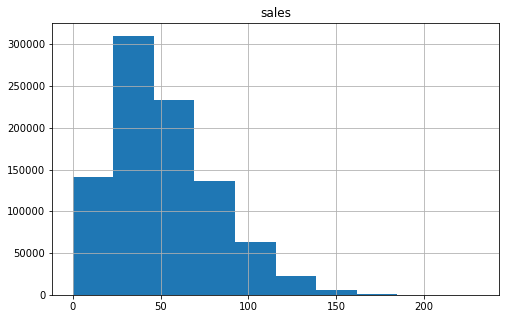

In [33]:
df2.hist('sales',figsize=(8,5))

In [34]:
df2['sales']= np.log1p(df2["sales"].values)
df2.head()

,date,sales,id,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
0,2013-01-01,2.639057,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
1,2013-01-02,2.484907,NaN,2,2,1,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
2,2013-01-03,2.708050,NaN,3,3,1,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
3,2013-01-04,2.639057,NaN,4,4,1,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
4,2013-01-05,2.397895,NaN,5,5,1,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0


array([[<AxesSubplot:title={'center':'sales'}>]], dtype=object)

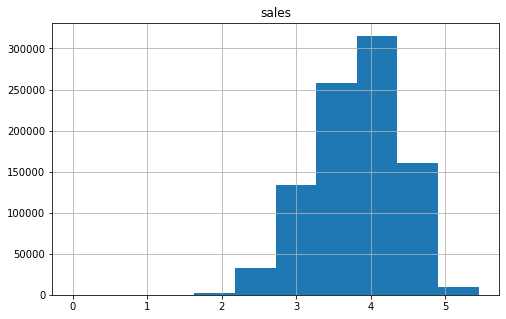

In [35]:
df2.hist('sales',figsize=(8,5))

<a id='split'></a>
<h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Splitting Train and Test</h1>

In [36]:
df_model= df2.copy()

In [37]:
df_model = df_model.sort_values("date").reset_index(drop = True)

In [38]:
train= df_model.loc[(df_model["date"] < "2017-01-01"), :]

val= df_model.loc[(df_model["date"] >= "2017-01-01") & (df_model["date"] < "2017-04-01"), :]

In [39]:
train

,date,sales,id,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
0,2013-01-01,2.639057,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
1,2013-01-01,2.833213,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
2,2013-01-01,3.044522,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
3,2013-01-01,3.555348,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
4,2013-01-01,2.995732,NaN,1,1,1,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730495,2016-12-31,4.060443,NaN,366,31,52,75.0,61.0,88.0,65.0,...,0,0,0,1,0,0,1,0,0,0
730496,2016-12-31,3.610918,NaN,366,31,52,48.0,54.0,53.0,49.0,...,0,0,0,1,0,0,1,0,0,0
730497,2016-12-31,3.367296,NaN,366,31,52,44.0,33.0,35.0,32.0,...,0,0,0,1,0,0,1,0,0,0
730498,2016-12-31,4.025352,NaN,366,31,52,59.0,75.0,73.0,58.0,...,0,0,0,1,0,0,1,0,0,0


In [40]:
val

,date,sales,id,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
730500,2017-01-01,3.663562,NaN,1,1,52,49.0,59.0,43.0,50.0,...,0,0,0,0,1,0,1,0,0,0
730501,2017-01-01,4.682131,NaN,1,1,52,131.0,167.0,142.0,145.0,...,0,0,0,0,1,0,1,0,0,0
730502,2017-01-01,4.077537,NaN,1,1,52,69.0,84.0,92.0,86.0,...,0,0,0,0,1,0,1,0,0,0
730503,2017-01-01,3.295837,NaN,1,1,52,40.0,34.0,33.0,33.0,...,0,0,0,0,1,0,1,0,0,0
730504,2017-01-01,3.367296,NaN,1,1,52,38.0,37.0,55.0,42.0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775495,2017-03-31,4.406719,NaN,90,31,13,55.0,62.0,64.0,58.0,...,0,0,0,0,1,0,0,1,0,0
775496,2017-03-31,3.555348,NaN,90,31,13,26.0,24.0,34.0,25.0,...,0,0,0,0,1,0,0,1,0,0
775497,2017-03-31,3.784190,NaN,90,31,13,33.0,30.0,31.0,27.0,...,0,0,0,0,1,0,0,1,0,0
775498,2017-03-31,3.988984,NaN,90,31,13,38.0,44.0,42.0,52.0,...,0,0,0,0,1,0,0,1,0,0


In [41]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [42]:
X_train = train[cols]
Y_train = train['sales']

X_val = val[cols]
Y_val = val['sales']

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((730500, 153), (730500,), (45000, 153), (45000,))

<a id='model'></a>
<h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Building and Running XGB Regressor</h1>

We will use SMAPE (Symmetric mean absolute percentage error (adjusted MAPE)) metric in order to evaluate the difference between forecasts and actual values. for SMAPE formula, click here.

In [53]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def xgb_smape(y_pred, y_true):
    smape_val = smape(np.expm1(preds), np.expm1(y_true))
    return 'SMAPE', smape_val, False

In [44]:
import xgboost as xgb

In [45]:
model= xgb.XGBRegressor()

In [46]:
from sklearn.metrics import explained_variance_score,mean_absolute_error, mean_squared_error, r2_score

In [54]:
%%time
first_model= model.fit(X_train, Y_train,
                       eval_metric= lambda y_pred, y_true: [xgb_smape(y_pred, y_true)])


print("VALID SMAPE:", smape(np.expm1(first_model.predict(X_val)), np.expm1(Y_val)))

print("\tExplained variance:", explained_variance_score(Y_val, first_model.predict(X_val)))
print("\tMean absolute error (MAE):", mean_absolute_error(Y_val, first_model.predict(X_val)))
print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(Y_val, first_model.predict(X_val))))
print("\tR2 score:", r2_score(Y_val, first_model.predict(X_val)))

VALID SMAPE: 13.906402092342663
	Explained variance: 0.8996825843615247
	Mean absolute error (MAE): 0.13537343964747361
	Root Mean squared error (RMSE): 0.17820782428144605
	R2 score: 0.8952793632469271
CPU times: total: 1h 19min 16s
Wall time: 22min 56s


Metrics:
- SMAPE: 13.906
- Explained variance: 0.899
- Mean absolute error (MAE): 0.135
- Root Mean squared error (RMSE): 0.178
- R2 score: 0.895

Error is 13,906%.

For instance, if we predicted that an item at store 1 will sell 100 units over the course of the following three months, it may actually be 100 ± 13,906 units.

**Feature importances**

Which features are the most important in the regression calculation?

In [69]:
feature_importance= pd.DataFrame(data   = first_model.feature_importances_,
                 index  = first_model.feature_names_in_,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(25)

,importance
sales_roll_mean_546,0.292823
season_0,0.107701
sales_lag_364,0.087897
season_2,0.027647
quarter_2,0.025921
dayofweek_0,0.025115
quarter_4,0.020946
sales_ewm_alpha_095_lag_91,0.016447
sales_ewm_alpha_07_lag_91,0.016316
sales_ewm_alpha_08_lag_91,0.012345


<Figure size 2160x720 with 0 Axes>

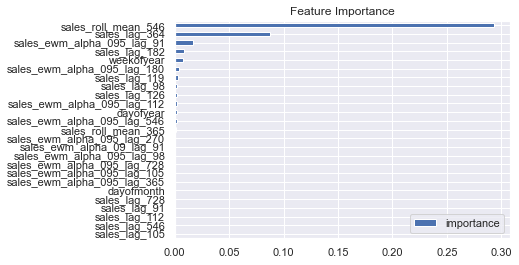

In [70]:
plt.figure(figsize=(30, 10))
feature_importance.head(25).sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

<a id='test'></a>
<h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Test Data Predictions</h1> 

Now, time to test our model on the test dataset. Again splitting data:

In [96]:
df_final_model= df2.copy()
train = df_final_model.loc[~df_final_model.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df_final_model.loc[df_final_model.sales.isna()]
X_test = test[cols]

In [97]:
X_train

,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
1,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
2,3,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
3,4,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
4,5,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,361,27,52,80.0,72.0,84.0,79.0,79.0,104.0,91.0,...,0,0,0,0,1,0,1,0,0,0
912996,362,28,52,82.0,89.0,90.0,78.0,89.0,89.0,122.0,...,0,0,0,0,1,0,1,0,0,0
912997,363,29,52,90.0,97.0,94.0,97.0,96.0,98.0,112.0,...,0,0,0,0,1,0,1,0,0,0
912998,364,30,52,103.0,97.0,97.0,93.0,92.0,92.0,119.0,...,0,0,0,0,1,0,1,0,0,0


In [98]:
Y_train

0         2.639057
1         2.484907
2         2.708050
3         2.639057
4         2.397895
            ...   
912995    4.158883
912996    4.094345
912997    4.317488
912998    4.143135
912999    4.418841
Name: sales, Length: 913000, dtype: float64

In [99]:
X_test

,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
0,1,1,1,12.0,14.0,22.0,16.0,12.0,15.0,18.0,...,0,0,0,0,0,1,1,0,0,0
1,2,2,1,18.0,18.0,21.0,20.0,26.0,21.0,23.0,...,0,0,0,0,0,1,1,0,0,0
2,3,3,1,15.0,27.0,20.0,13.0,24.0,22.0,23.0,...,0,0,0,0,0,1,1,0,0,0
3,4,4,1,20.0,23.0,20.0,26.0,29.0,26.0,31.0,...,0,0,0,0,0,1,1,0,0,0
4,5,5,1,19.0,28.0,28.0,28.0,28.0,38.0,32.0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,86,27,13,41.0,54.0,67.0,68.0,68.0,81.0,79.0,...,0,0,0,0,0,1,0,1,0,0
44996,87,28,13,63.0,51.0,67.0,60.0,76.0,81.0,80.0,...,0,0,0,0,0,1,0,1,0,0
44997,88,29,13,59.0,63.0,72.0,66.0,73.0,87.0,82.0,...,0,0,0,0,0,1,0,1,0,0
44998,89,30,13,74.0,75.0,72.0,67.0,66.0,81.0,90.0,...,0,0,0,0,0,1,0,1,0,0


In [100]:
test_model= xgb.XGBRegressor(colsample_bytree= 0.3, learning_rate= 0.1, max_depth= 3, n_estimators= 1000)

In [102]:
start = time()
xgb_params= {"colsample_bytree": 0.3, 
             "learning_rate": 0.1, 
             "max_depth": 3,
             "n_estimators": 1000,
             "verbose": 100,
             "num_boost_round": model.best_iteration}

xgbtrain_all= xgb.DMatrix(data=X_train, label=Y_train)

test_model= xgb.train(xgb_params, xgbtrain_all,                      
                      num_boost_round=model.best_iteration)

train_time = time() - start
start = time()
test_preds = test_model.predict(xgb.DMatrix(X_test))
predict_time = time()-start

[21:17:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators", "num_boost_round", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [103]:
test_preds

array([2.5852873, 2.7422605, 2.7207162, ..., 4.3781724, 4.4687185,
       4.5331235], dtype=float32)

In [104]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)
submission_df.head()

,id,sales
0,0,12.267100
1,1,14.522033
2,2,14.191199
3,3,14.727979
4,4,16.821434


In [105]:
submission_df.to_csv('submission.csv', index=False)

<div style="color:white; font-size:125%; text-align:left; display:fill; border-radius:5px; background-color:#1E90FF; overflow:hidden">Thanks for reading. I hope you enjoy it and that it was helpful to you.<br>Please don't forget to follow me and give an upvote on</br>
👇👇👇
</div>

**<a href="https://www.kaggle.com/drindeng/" target="_blank" rel="noopener noreferrer">[Kaggle]</a> | 
<a href="https://github.com/drindeng" target="_blank" rel="noopener noreferrer">[GitHub]</a> |
<a href="https://www.linkedin.com/in/turgay-turker/" target="_blank" rel="noopener noreferrer">[Linkedin]</a>**